In [2]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('..\dataset\Employment_Unemployment_GDP_data.csv')

output_path = r"..\output\figure"
os.makedirs(output_path, exist_ok=True)

print(df.head())

df.rename(columns={
    'Country Name': 'Country',
    'Employment Sector: Agriculture': 'Labor_Agriculture',
    'Employment Sector: Industry': 'Labor_Industry',
    'Employment Sector: Services': 'Labor_Services',
    'Unemployment Rate': 'Unemployment_Rate',
    'GDP (in USD)': 'GDP'
}, inplace=True)

df.sample(5)


  Country Name  Year  Employment Sector: Agriculture  \
0      Albania  1991                       53.299533   
1      Algeria  1991                       24.118566   
2       Angola  1991                       40.071857   
3    Argentina  1991                       13.669999   
4      Armenia  1991                       54.263252   

   Employment Sector: Industry  Employment Sector: Services  \
0                    12.172764                    34.527781   
1                    25.067734                    50.813700   
2                     8.163345                    51.764822   
3                    28.505903                    57.824098   
4                    15.790454                    29.946294   

   Unemployment Rate  GDP (in USD)  
0             10.304  1.099559e+09  
1             20.600  4.571568e+10  
2             16.855  1.060378e+10  
3              5.440  1.897200e+11  
4              1.783  2.069870e+09  


,Country,Year,Labor_Agriculture,Labor_Industry,Labor_Services,Unemployment_Rate,GDP
4260,Papua New Guinea,2014,22.357722,9.105544,68.536734,2.536,2.321082e+10
4879,Brazil,2018,9.056941,20.530048,70.413013,12.329,1.916934e+12
2276,South Africa,2003,19.365722,27.887520,52.746765,22.629,1.970190e+11
703,Bahrain,1995,2.022381,28.565846,69.411398,1.047,6.651181e+09
3029,Uruguay,2007,10.674477,21.679099,67.646425,9.403,2.379777e+10


In [4]:
# 3.2.1. Xử lý giá trị thiếu
df.fillna(df.mean(numeric_only=True), inplace=True)
print("\n Đã xử lý giá trị thiếu.")


 Đã xử lý giá trị thiếu.


In [5]:
# 3.2.2. Xóa outlier (sử dụng IQR)
numeric_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(" Dữ liệu sau khi loại bỏ outlier:", df.shape)



 Dữ liệu sau khi loại bỏ outlier: (4671, 7)


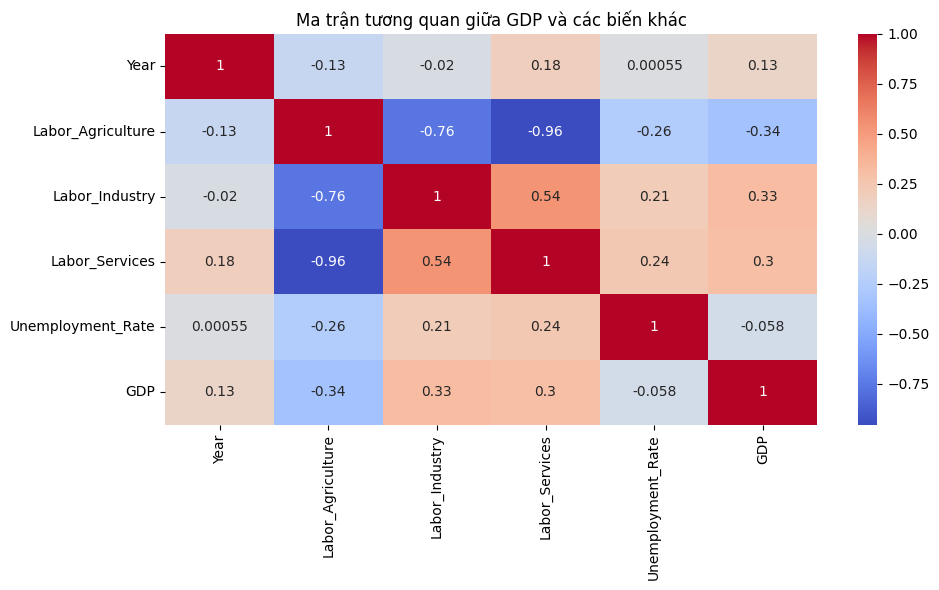

In [6]:
# 3.2.3. Ma trận tương quan
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan giữa GDP và các biến khác")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "heatmap_correlation.png"))
plt.show()
plt.close()


In [7]:
print(df.columns.tolist())

['Country', 'Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate', 'GDP']


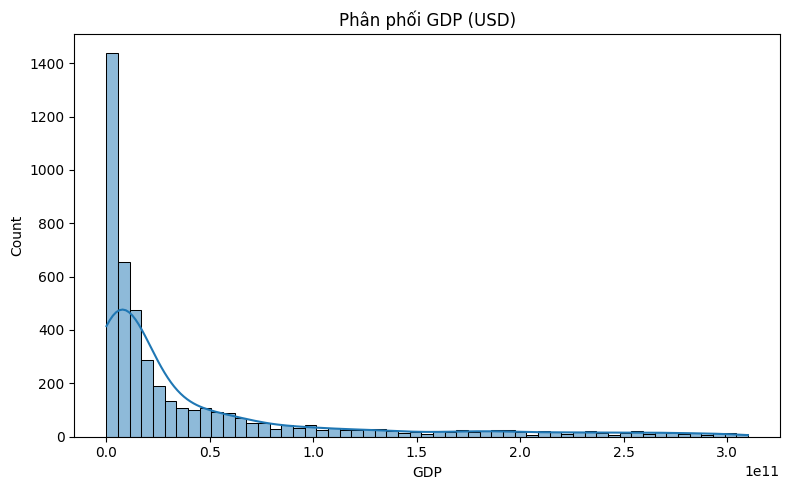

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['GDP'], kde=True)
plt.title("Phân phối GDP (USD)")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "gdp_distribution.png"))
plt.show()
plt.close()

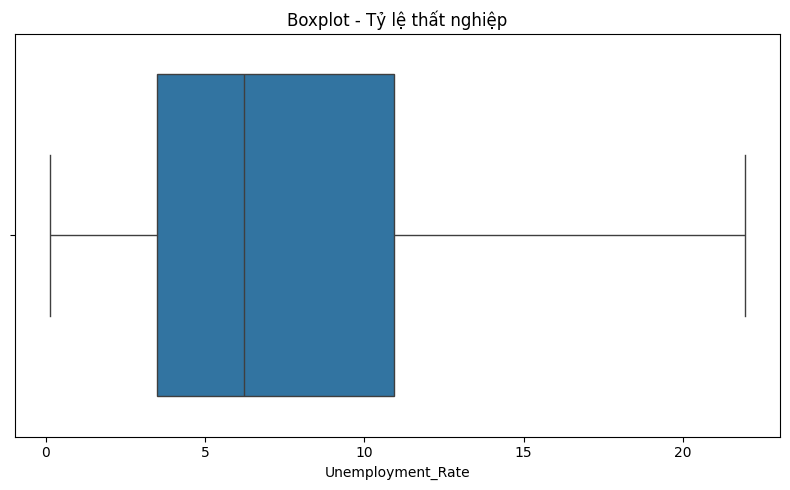

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Unemployment_Rate'])
plt.title("Boxplot - Tỷ lệ thất nghiệp")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "unemployment_boxplot.png"))
plt.show()
plt.close()

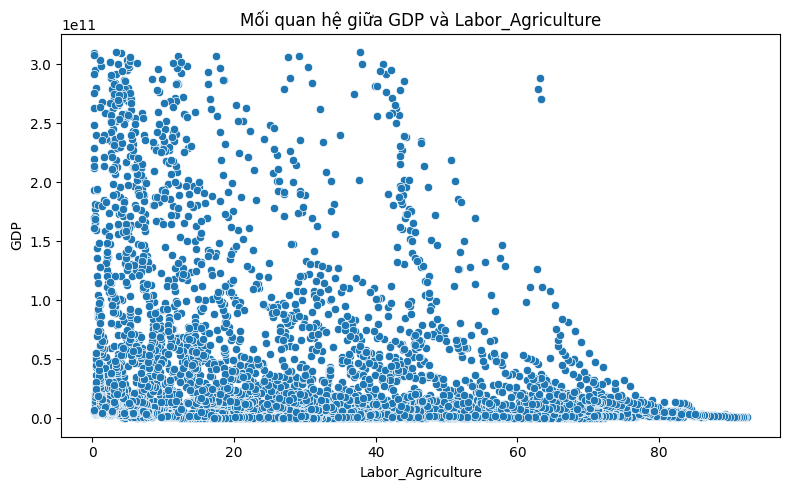

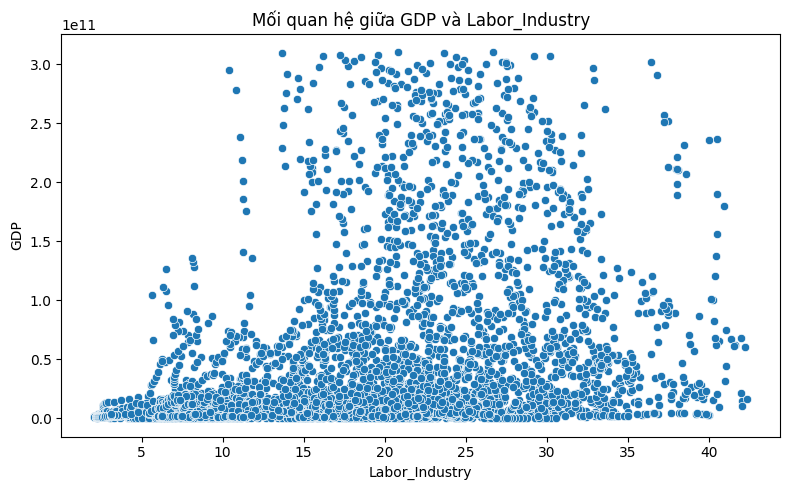

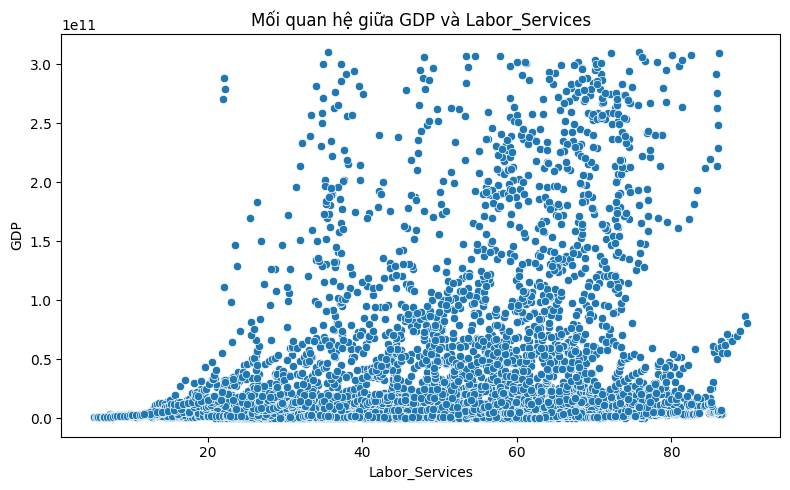

In [10]:
for col in ['Labor_Agriculture', 'Labor_Industry', 'Labor_Services']:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df[col], y=df['GDP'])
    plt.title(f"Mối quan hệ giữa GDP và {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"scatter_{col}.png"))
    plt.show()
    plt.close()


In [ ]:
le = LabelEncoder()
df["Country_Code"] = le.fit_transform(df["Country"])
os.makedirs(r"..\output\model", exist_ok=True)
joblib.dump(le, r"..\output\model\country_encoder.joblib")

print(" Đã lưu encoder tại ..\\output\\model\\country_encoder.joblib")

 Đã lưu encoder tại ..\output\model\country_encoder.joblib


In [24]:

X = df[['Country_Code', 'Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']]
y = df['GDP']

cols_to_scale = ['Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']


scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
joblib.dump(scaler, r"..\output\model\scaler_country.joblib")
print(" Đã chuẩn hóa dữ liệu thành công!")
print(X_scaled.head())

 Đã chuẩn hóa dữ liệu thành công!
   Country_Code  Year  Labor_Agriculture  Labor_Industry  Labor_Services  \
0             1 -1.64               0.85           -0.77           -0.75   
1             2 -1.64              -0.35            0.74            0.12   
2             3 -1.64               0.30           -1.24            0.17   
3             4 -1.64              -0.78            1.15            0.50   
4             5 -1.64               0.89           -0.34           -1.00   

   Unemployment_Rate  
0               0.50  
1               2.45  
2               1.74  
3              -0.42  
4              -1.11  


In [13]:
# 3.4.3. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(" Đã chia dữ liệu train/test.")

 Đã chia dữ liệu train/test.


In [14]:
from lazypredict.Supervised import LazyRegressor
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)
print(models.head())


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 6
[LightGBM] [Info] Start training from score 44393026189.796577
                               Adjusted R-Squared  R-Squared           RMSE  \
Model                                                                         
XGBRegressor                                 0.94       0.94 17362357422.15   
ExtraTreesRegressor                          0.91       0.91 21113349279.64   
LGBMRegressor                                0.90       0.90 22336126202.60   
HistGradientBoostingRegressor                0.89       0.89 22919483562.18   
RandomForestRegressor                        0.85       0.85 26967991165.16   

                               Time Taken  
Model                                      
XGBRegre

In [15]:
results_path = r"..\output\metric\metrics.csv"
if not os.path.exists(results_path):
    with open(results_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "MAE", "RMSE", "R2"])
def evaluate_model(name, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n📊 {name} results:")
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    with open(results_path, mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([name, mae, rmse, r2])

    # Đồng thời trả về dict nếu muốn tạo DataFrame sau
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}


📊 Extra Trees Regressor results:
MAE: 10492903123.806 | RMSE: 21113349279.637 | R2: 0.911


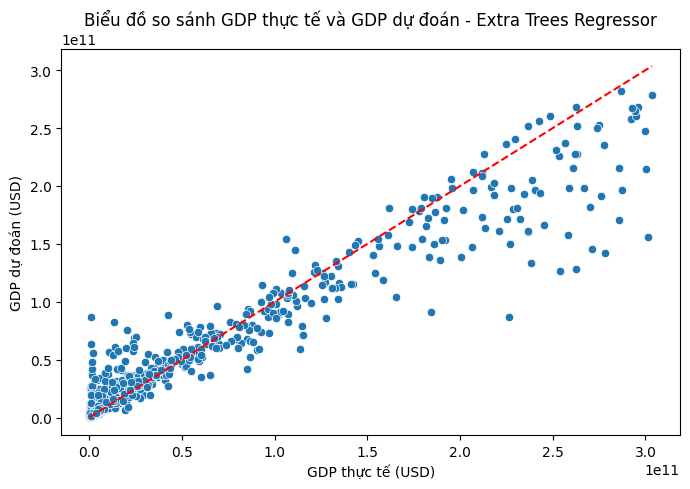

✅ Đã lưu: ExtraTree_actual_vs_predicted.png


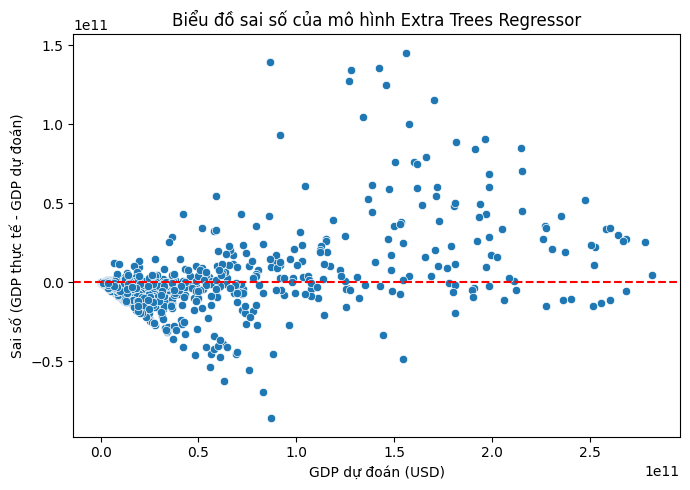

✅ Đã lưu: ExtraTree_residuals.png


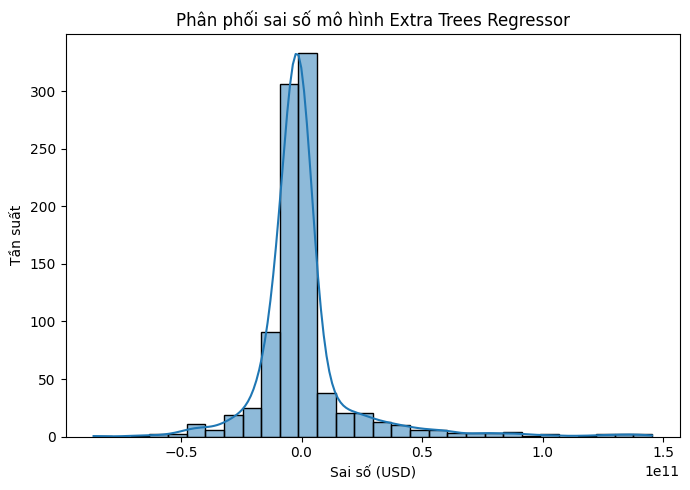

✅ Đã lưu: ExtraTree_error_distribution.png


['..\\output\\model\\extra_trees_model.joblib']

In [16]:
tr = ExtraTreesRegressor(n_estimators=100, random_state=42)
tr.fit(X_train, y_train)
y_pred_tr = tr.predict(X_test)
results_tr = evaluate_model("Extra Trees Regressor", tr, y_test, y_pred_tr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_tr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Extra Trees Regressor")
# Vẽ thêm đường chéo để thấy độ khớp
min_val = min(min(y_test), min(y_pred_tr))
max_val = max(max(y_test), max(y_pred_tr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_actual_vs_predicted.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_actual_vs_predicted.png")

# === 2️⃣ Biểu đồ sai số (Residual Plot) ===
residuals = y_test - y_pred_tr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_tr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Extra Trees Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_residuals.png")

# === 3️⃣ Biểu đồ phân phối sai số (Histogram) ===
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Extra Trees Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_error_distribution.png")
plt.show()

model_path = r"..\output\model\extra_trees_model.joblib"
joblib.dump(tr, model_path)


📊 Gradient Boosting Regressor results:
MAE: 28019430308.369 | RMSE: 42893524212.377 | R2: 0.632


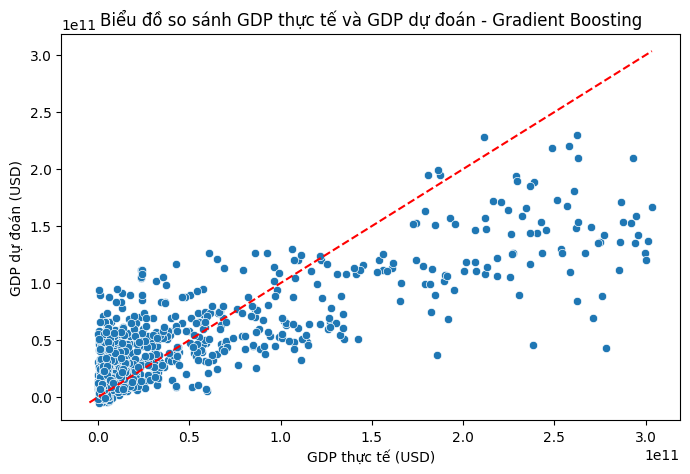

 Đã lưu: GradientBoosting_actual_vs_predicted.png


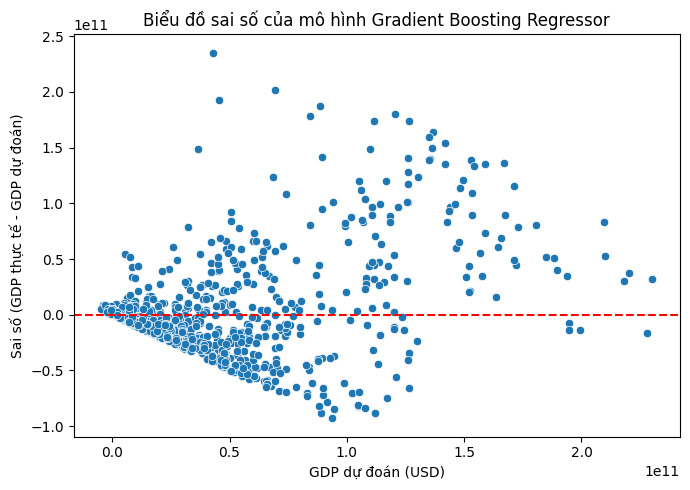

✅ Đã lưu: GradientBoosting_residuals.png


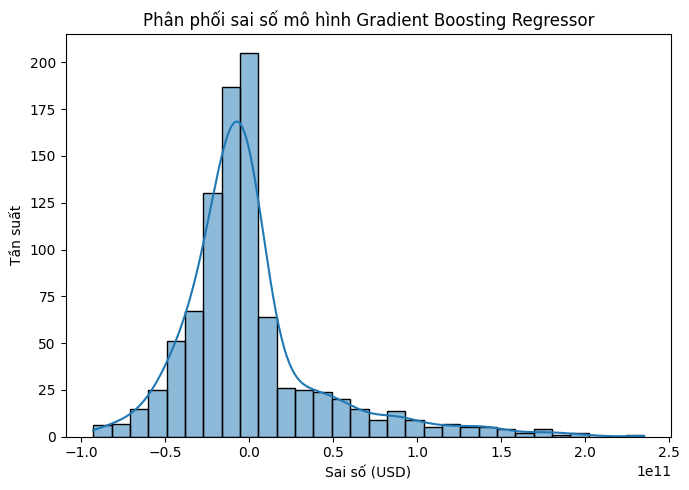

✅ Đã lưu: GraidentBoosting_error_distribution.png


['..\\output\\model\\gradient_boosting_model.joblib']

In [17]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results_gb = evaluate_model("Gradient Boosting Regressor", gb, y_test, y_pred_gb)
model_path = r"..\output\model\gradient_boosting_model.joblib"
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_gb)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Gradient Boosting")
min_val = min(min(y_test), min(y_pred_gb))
max_val = max(max(y_test), max(y_pred_gb))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: GradientBoosting_actual_vs_predicted.png")


residuals = y_test - y_pred_gb
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_gb, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Gradient Boosting Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: GradientBoosting_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Gradient Boosting Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: GraidentBoosting_error_distribution.png")
joblib.dump(gb, model_path)


📊 Linear Regression results:
MAE: 45388002094.637 | RMSE: 65415838546.941 | R2: 0.144


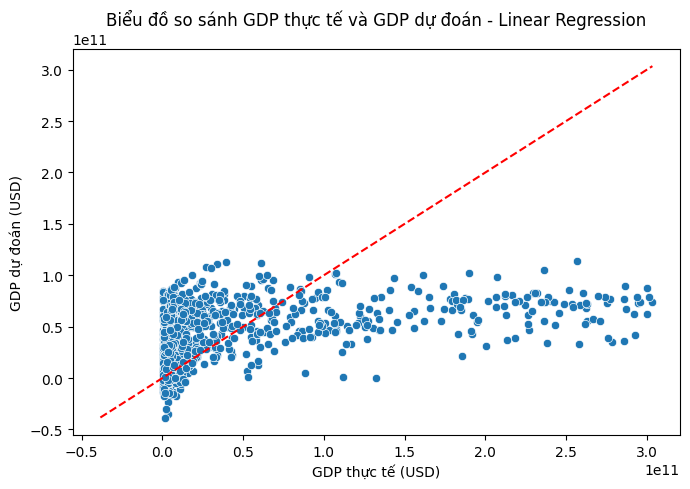

 Đã lưu: LinearRegression_actual_vs_predicted.png


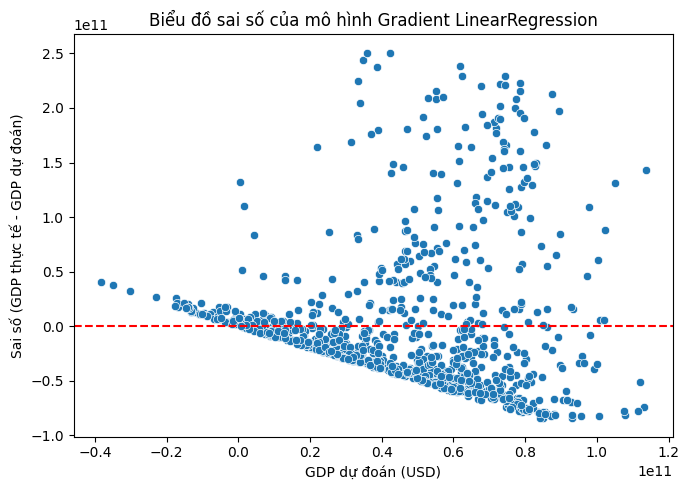

✅ Đã lưu: LinearRegression_residuals.png


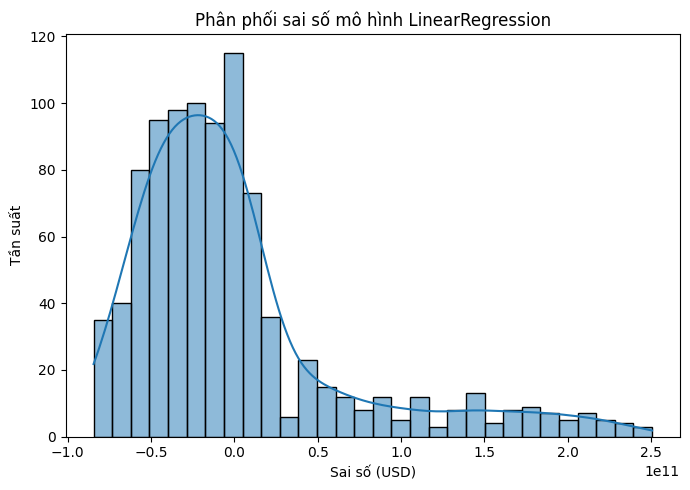

['..\\output\\model\\linear_regression_model.joblib']

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results_lr = evaluate_model("Linear Regression", lr, y_test, y_pred_lr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Linear Regression")
min_val = min(min(y_test), min(y_pred_lr))
max_val = max(max(y_test), max(y_pred_lr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: LinearRegression_actual_vs_predicted.png")


residuals = y_test - y_pred_lr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Gradient LinearRegression")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: LinearRegression_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình LinearRegression")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_error_distribution.png"))
plt.show()
plt.close()

model_path = r"..\output\model\linear_regression_model.joblib"
joblib.dump(lr, model_path)


📊 Random Forest results:
MAE: 13879094732.652 | RMSE: 26992142082.909 | R2: 0.854


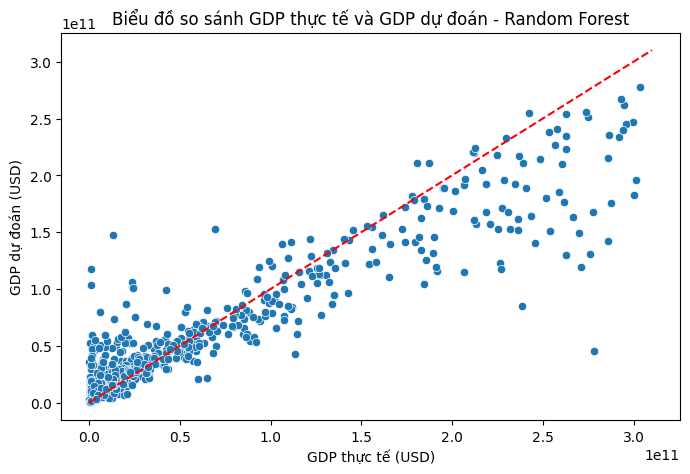

 Đã lưu: RandomForest_actual_vs_predicted.png


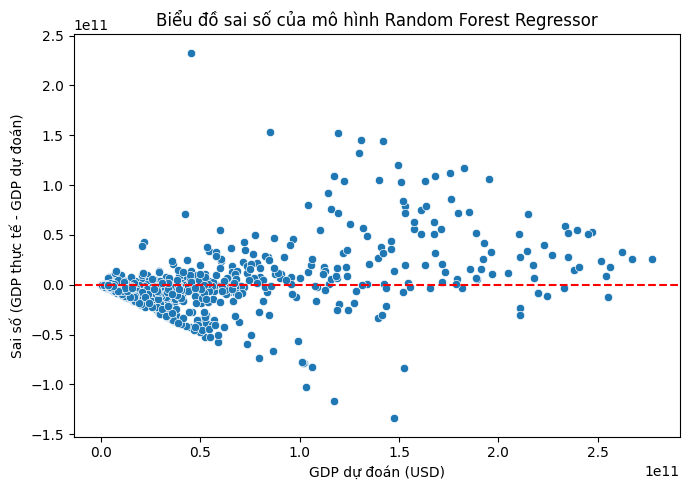

✅ Đã lưu: RandomForest_residuals.png


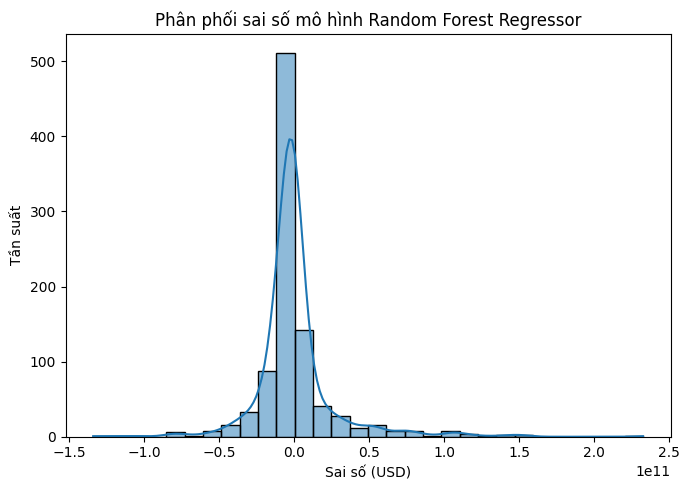

['..\\output\\model\\random_forest_model.joblib']

In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results_rf = evaluate_model("Random Forest", rf, y_test, y_pred_rf)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Random Forest")
min_val = min(min(y_test), min(y_pred_rf))
max_val = max(max(y_test), max(y))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: RandomForest_actual_vs_predicted.png")


residuals = y_test - y_pred_rf
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Random Forest Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: RandomForest_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Random Forest Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_error_distribution.png"))
plt.show()
plt.close()
model_path = r"..\output\model\random_forest_model.joblib"
joblib.dump(rf, model_path)


📊 Support Vector Regression results:
MAE: 40916606256.594 | RMSE: 77343633742.410 | R2: -0.196


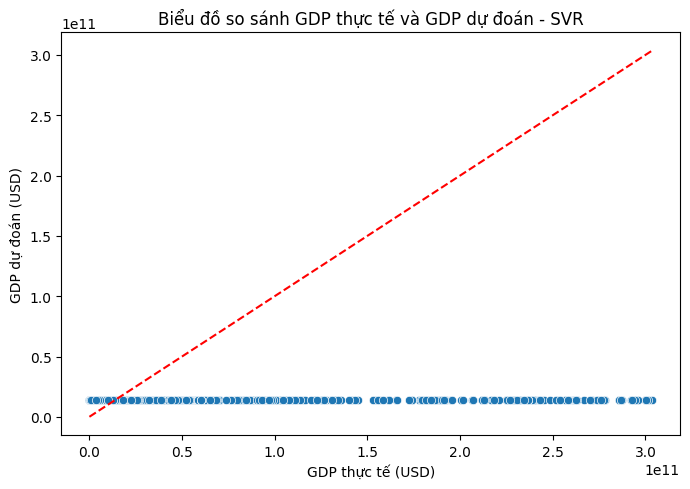

✅ Đã lưu: svr_actual_vs_predicted.png


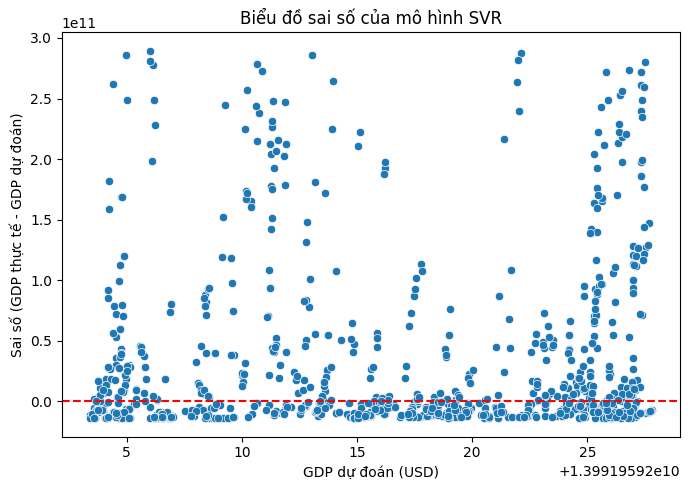

✅ Đã lưu: svr_residuals.png


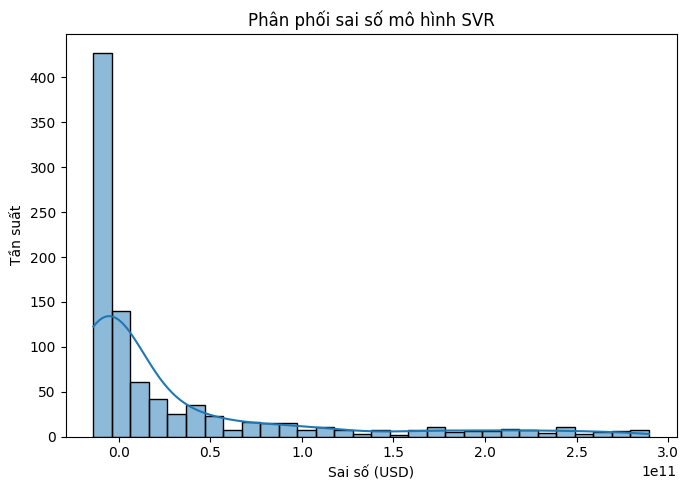

✅ Đã lưu: svr_error_distribution.png


['..\\output\\model\\svr_model.joblib']

In [20]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
results_svr = evaluate_model("Support Vector Regression", svr, y_test, y_pred_svr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_svr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - SVR")

min_val = min(min(y_test), min(y_pred_svr))
max_val = max(max(y_test), max(y_pred_svr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_actual_vs_predicted.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_actual_vs_predicted.png")


residuals = y_test - y_pred_svr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_svr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình SVR")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình SVR")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_error_distribution.png")
model_path = r"..\output\model\svr_model.joblib"
joblib.dump(svr, model_path)

In [21]:
results = pd.DataFrame([results_lr, results_rf, results_svr,results_tr,results_gb])
print("\n📈 So sánh mô hình:\n", results)



📈 So sánh mô hình:
                          Model            MAE           RMSE    R2
0            Linear Regression 45388002094.64 65415838546.94  0.14
1                Random Forest 13879094732.65 26992142082.91  0.85
2    Support Vector Regression 40916606256.59 77343633742.41 -0.20
3        Extra Trees Regressor 10492903123.81 21113349279.64  0.91
4  Gradient Boosting Regressor 28019430308.37 42893524212.38  0.63


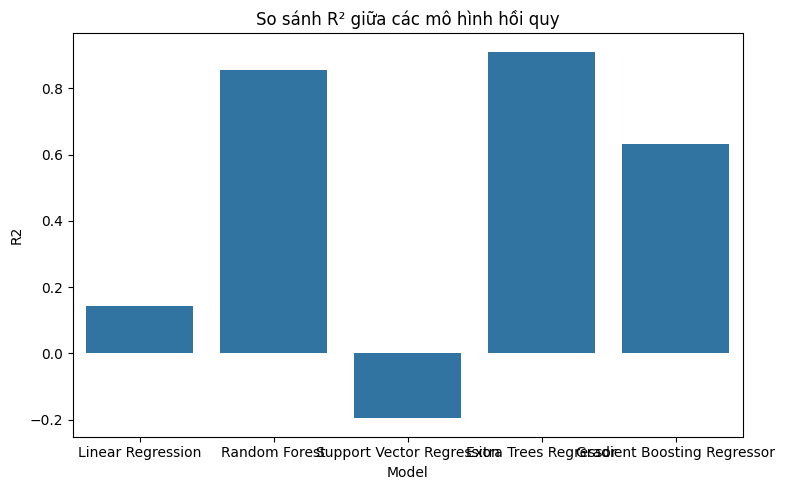

In [22]:
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="R2")
plt.title("So sánh R² giữa các mô hình hồi quy")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "model_comparison.png"))
plt.show()
plt.close()

In [25]:


model = joblib.load(r"..\output\model\extra_trees_model.joblib")

country = input("Nhập tên quốc gia: ")
year = int(input("Năm: "))
agri = float(input("Lao động nông nghiệp (%): "))
ind = float(input("Lao động công nghiệp (%): "))
serv = float(input("Lao động dịch vụ (%): "))
unemp = float(input("Tỷ lệ thất nghiệp (%): "))

country_code = le.transform([country])[0]

# Tạo DataFrame
new_data = pd.DataFrame({
    'Country_Code': [country_code],
    'Year': [year],
    'Labor_Agriculture': [agri],
    'Labor_Industry': [ind],
    'Labor_Services': [serv],
    'Unemployment_Rate': [unemp]
})

# Chuẩn hóa các cột liên tục
cols_to_scale = ['Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']
new_scaled = new_data.copy()
new_scaled[cols_to_scale] = scaler.transform(new_data[cols_to_scale])

# Dự đoán GDP
pred = model.predict(new_scaled)[0]
print(f"\n🌍 Quốc gia: {country}")
print(f"📅 Năm: {year}")
print(f"📈 Dự đoán GDP: {pred:,.2f} USD")


ValueError: invalid literal for int() with base 10: ''